In [1]:
!pip install qiskit_ibm_runtime
!pip install qiskit_aer

  Using cached qiskit_ibm_runtime-0.30.0-py3-none-any.whl.metadata (19 kB)
  Using cached requests_ntlm-1.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached ibm_platform_services-0.57.1-py3-none-any.whl.metadata (9.1 kB)
  Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached ibm_cloud_sdk_core-3.21.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.3.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached pyspnego-0.11.1-py3-none-any.whl.metadata (5.4 kB)
  Using cached pbr-6.1.0

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from qiskit import *                 
from qiskit_aer import *             
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import *
from collections import defaultdict

In [260]:
#user_num = int(input("Enter the max for your QRNG range:"))   # User input for max range 
#num_qubits = int(np.ceil(np.log2(user_num)))                  # Obtains number of qubits for the circuit
num_qubits = 2

In [3]:
def number_generator_simulator(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)                 # Creates circuit with number of qubits obtained
    circ.h(range(num_qubits))                                     # Applies a hadamard gate to all qubits
    circ.measure(range(num_qubits), range(num_qubits))            # Measures all qubits and assigns them to classical bits

    simulator = AerSimulator()                                         # Lets us use the Aer Simulator 
    compiled_circuit = transpile(circ, simulator)                      # Compiled circuit using Aer 
    result = simulator.run(compiled_circuit, shots = 50).result()     # Result with the 10000 shots as to not run forever on IBM machines
    counts = result.get_counts()                                       # Assigns counts with the result
    
    return counts

In [34]:
# For mod 2 method
def obtain_rand(counts):
    # Get all values
    max_value = max(counts.values())
    max_keys = [key for key, value in counts.items() if value == max_value]
    max_dict = {key: counts[key] for key in max_keys}
    # print(max_value)
    # print(max_keys)
    # print(max_dict)
    # Sum all Q-bit entries for tied keys
    # Get the first key
    new_key = [int(i) for i in max_keys[0]]
    for i in range(1, len(max_keys)):
        for j in range (0, len(new_key)):
            new_key[j] += int(max_keys[i][j])

    super_new_key = ''
    # print(new_key)
    # Bitwise XOR (mod % 2) on each qubit
    for i in range (0, len(new_key)):
        # super_new_key[i] = str(int(new_key[i]) % 2)
        super_new_key += str(int(new_key[i]) % 2)

    return super_new_key
            
            

In [31]:
# For iterative method
def obtain_ties(counts):
    max_value = max(counts.values())
    max_keys = [key for key, value in counts.items() if value == max_value]
    max_dict = {key: counts[key] for key in max_keys}

    while (len(max_keys) > 1):
        # print(max_keys)
        max_keys = tie_breaker(max_keys)

    return max_keys[0]
        

def tie_breaker(ties):
    new_num_qubits = int(np.ceil(np.log2(len(ties))))
    # print("new q: ", new_num_qubits)
    counts = number_generator_simulator(new_num_qubits)
    # Discard out of range
    counts = {key: value for key, value in counts.items() if int(key,2) < len(ties)}
    
    max_value = max(counts.values()) # Max among the ties
    max_keys = [key for key, value in counts.items() if value == max_value] # Keys (indexes!) that tied
    max_dict = {key: counts[key] for key in max_keys} # Dictionary of tied index->value's
    # print("Max key: ", max_keys)
    
    # Need to use new ties (indexes of original ties) to index which ties make it
    new_ties = []
    # print(max_keys)
    for key in max_keys:
        # Ensure that 'key' is treated correctly for indexing
        index = int(key, 2)  # Convert binary string key to integer
        new_ties.append(ties[index])  # Append the corresponding original tie

    return new_ties

In [37]:
# For concatenation method
def concatenation(num_qubits, division_size):
    extra = num_qubits % division_size
    iterations = int((num_qubits - extra) / division_size)
    final_output = []

    for iteration in range(iterations):
        division_chunk = None

        while division_chunk is None:
            counts = number_generator_simulator(division_size)
            division_chunk = check_tie(counts)
        final_output.append(division_chunk)

    if extra != 0:
        division_chunk = None

        while division_chunk is None:
            counts = number_generator_simulator(extra)
            division_chunk = check_tie(counts)
        final_output.append(division_chunk)

    return ''.join(final_output)

def check_tie(counts):
    max_value = max(counts.values())
    max_keys = [key for key, value in counts.items() if value == max_value]

    if len(max_keys) > 1:
        return None
    else:
        return max_keys[0]

In [6]:
# Memory limitations (simulator only 30) -> "chunk" bit input
# chunk_size is # of qubits to divide chunk in to
def iterativeChunker(chunk_size):
    finalRN = ''
    for i in range (0, int(num_qubits/chunk_size)):
        counts = number_generator_simulator(chunk_size)
        rand_value = obtain_ties(counts)
        finalRN += rand_value

    remainderSize = num_qubits - np.floor(num_qubits/chunk_size)*chunk_size
    if remainderSize != 0:
        counts = number_generator_simulator(remainderSize)
        rand_value = obtain_ties(counts)
        finalRN += rand_value

    return finalRN

def modChunker(chunk_size):
    finalRN = ''
    for i in range (0, int(num_qubits/chunk_size)):
        counts = number_generator_simulator(chunk_size)
        rand_value = obtain_rand(counts)
        finalRN += rand_value

    remainderSize = num_qubits - np.floor(num_qubits/chunk_size)*chunk_size
    if remainderSize != 0:
        counts = number_generator_simulator(remainderSize)
        rand_value = obtain_ties(counts)
        finalRN += rand_value

    return finalRN

In [19]:
# Using iterative method
chunk_size = 30
for i in range (0, 100):
    final_val = iterativeChunker(chunk_size)
    print(f'Final random qubit state:', final_val)

In [20]:
# Using mod 2 method
for i in range (0, 100):
    rand_value = modChunker(chunk_size)
    # print(f'Data:', counts)
    print(f'Final random qubit state:', rand_value)



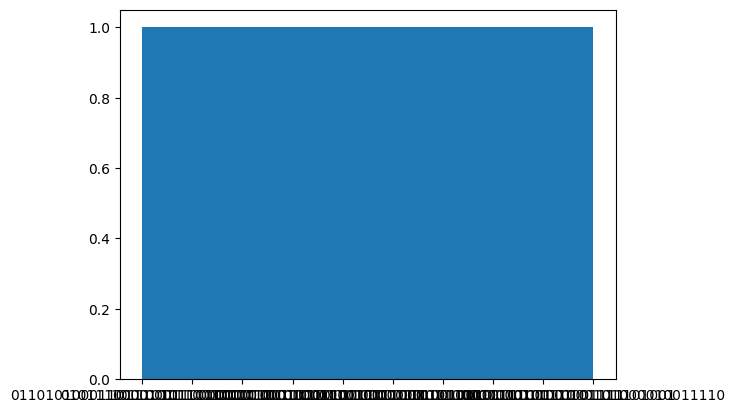

In [17]:
num_qubits = 30
modDict = []
for i in range (0, 10):
    counts = number_generator_simulator(num_qubits)
    rand_val = obtain_rand(counts)
    modDict.append(rand_val)
plt.hist(modDict)
plt.show()

# num_qubits = 5
# modDict = { i:0 for i in range(0,2**num_qubits)}
# for i in range (0, 50):
#     counts = number_generator_simulator(num_qubits)
#     rand_val = obtain_rand(counts)
#     modDict[int(rand_val,2)] += 1


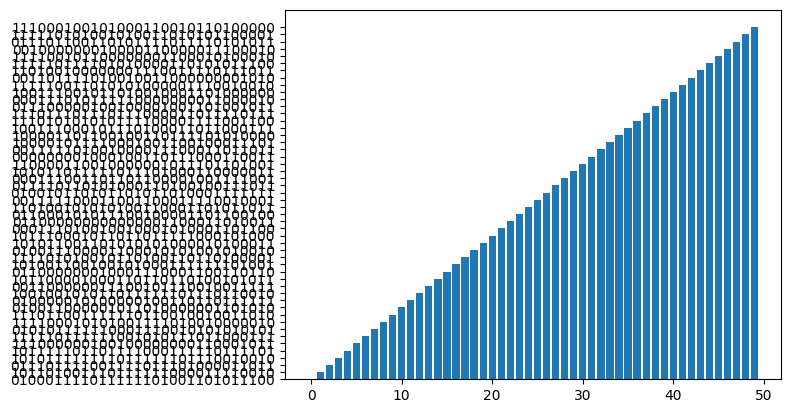

In [10]:
X = [i for i in range(0, len(modDict))]
plt.bar(X, modDict)
plt.show()

In [ ]:
plt.bar(modDict.keys(), modDict.values())
plt.show()

In [ ]:
num_qubits = 5

modDict = { i:0 for i in range(0,2**num_qubits)}

for i in range (0, 1000):
    counts = number_generator_simulator(num_qubits)
    rand_val = obtain_ties(counts)
    modDict[int(rand_val,2)] += 1

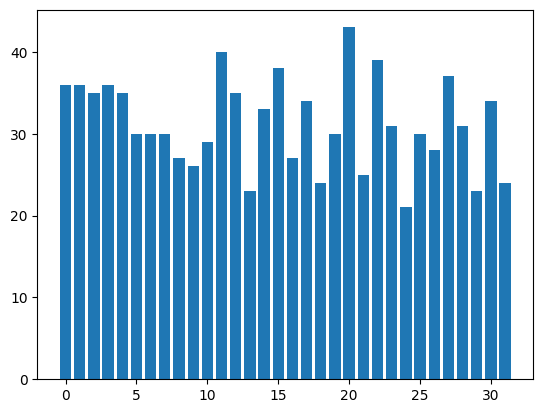

In [288]:
plt.bar(modDict.keys(), modDict.values())
plt.show()

In [43]:
QiskitRuntimeService.save_account(channel = "ibm_quantum", token = '0ec93270be1e812adf8a8fb1a827d0c7f414e66dd069a28072667e4dbc308af6eb301cb6d2dd134f70677bf88b1d05722d4e57acf788a17bb057ea1e636c0526',
                                    overwrite = True, set_as_default = True)
service = QiskitRuntimeService(instance = "ibm-q/open/main")

# Create possible brisbanes
brisbane = service.backend('ibm_brisbane')
sherbrooke = service.backend('ibm_sherbrooke')
# Generate_preset_pass_manager
pm = generate_preset_pass_manager(backend = brisbane, optimization_level=3)

In [38]:
# Generated simulated quantum circuit bit data
num_qubits = 10000
chunk_size = 10
outputBit = concatenation(num_qubits, chunk_size)

In [39]:
with open('simulator_concat-10_10000.txt', 'w') as f:
    f.write(outputBit)
    f.write(' 1')